# Processing Sequences using RNNs and CNNs

Understanding the fundamentals of RNNs and using them to forecast a time series.

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


## Basic RNNs

Generating the dataset:

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

Forcasting 1 step ahead:

In [3]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1) # one step ahead
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

Saving figure time_series_plot


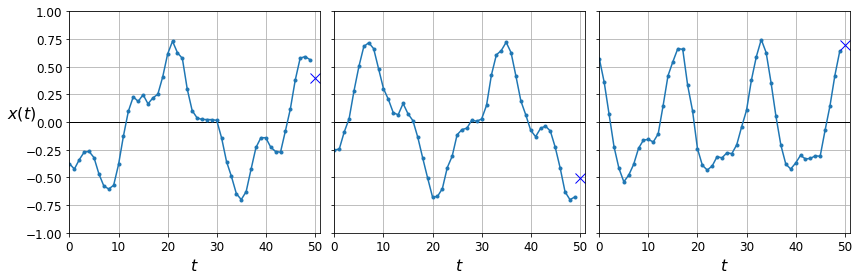

In [4]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()


### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [5]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

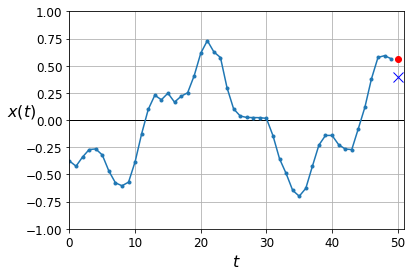

In [6]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Another approach is to use a fully connected network.

Linear predictions:

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0062

In [8]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 969us/step - loss: 0.0042


0.004168087150901556

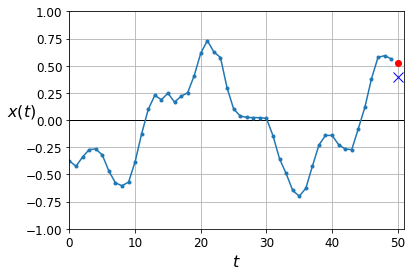

In [9]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a simple RNN

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1]) # input sequence length is not specified (None) as RNN can process any number of time steps
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0116 - val_loss: 0.011

In [11]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0109


0.010881561785936356

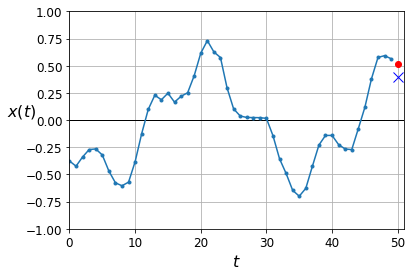

In [12]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1),
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)

history = model.fit(X_train, y_train, epochs=20,  validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0296 - val_loss: 0.0057
Epoch 2/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 4/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 6/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 7/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 8/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 9/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 10/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0033 - val_l

In [14]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 8ms/step - loss: 0.0032


0.0031756404787302017

The last layer in above model is not ideal: it must have a single unit because we want to forecast a univariate time series, and this means we have a single output value per time step.

SimpleRNN uses tanh activation function by default.

For above reasons, it is preferable to replace the output layer with a Dense layer:

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1),
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)

history = model.fit(X_train, y_train, epochs=20,  validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0133 - val_loss: 0.0037
Epoch 2/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 3/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 4/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 5/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 6/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 7/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 8/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 9/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 10/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0032 - val_lo

Now, it converges faster and performs just as well. 

### Forecasting Several Time Steps Ahead

One way is to use the model we already trained, make it predict the next value, then add that value to the inputs, and use the model again to predict the following value, and so on:

In [16]:
series = generate_time_series(1, n_steps + 10)

X_new, Y_new = series[:, :n_steps], series[:, n_steps:]

X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :] # predict one value
    X = np.concatenate([X, y_pred_one], axis=1) # add the predicted value to the input
    
Y_pred = X[:, n_steps:]

Saving figure forecast_ahead_plot


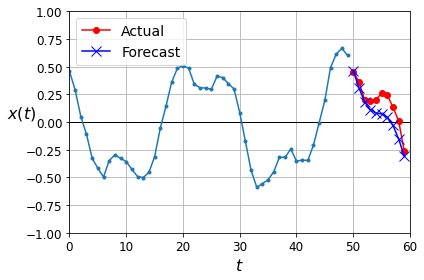

In [17]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0]) #1
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual") #2
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10) #3
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()    

Second option is to train an RNN to predict all 10 next values at once.

We first need to regenerate the sequences with 9 more time steps.

In [18]:
series = generate_time_series(10000, n_steps + 10) # 10 steps ahead
X_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [19]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.05))

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0661 - val_loss: 0.0385
Epoch 2/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0977 - val_loss: 0.1784
Epoch 3/20
219/219 [==============================] - 5s 23ms/step - loss: 0.1795 - val_loss: 0.1618
Epoch 4/20
219/219 [==============================] - 5s 24ms/step - loss: 0.1678 - val_loss: 0.2088
Epoch 5/20
219/219 [==============================] - 5s 23ms/step - loss: 0.1646 - val_loss: 0.1718
Epoch 6/20
219/219 [==============================] - 5s 24ms/step - loss: 0.1657 - val_loss: 0.1571
Epoch 7/20
219/219 [==============================] - 5s 23ms/step - loss: 0.1628 - val_loss: 0.1488
Epoch 8/20
219/219 [==============================] - 6s 27ms/step - loss: 0.1633 - val_loss: 0.2171
Epoch 9/20
219/219 [==============================] - 7s 31ms/step - loss: 0.1649 - val_loss: 0.1544
Epoch 10/20
219/219 [==============================] - 6s 29ms/step - loss: 0.1667 - val_lo

Now, predicting the next 10 values at once easily:

In [20]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

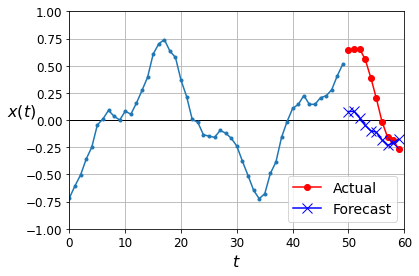

In [21]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Instead of training the model to forecast the next 10 values at the very last step,  we can train it to forecast the next 10 values at each and every time step.

Instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [22]:
np.random.seed(42)
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vectors
for step_head in range(10):
    Y[:,:, step_head - 1] = series[:,step_head:step_head + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test  = Y[9000:]

In [23]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [24]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

# all outputs are needed for training, 
# but only the output at the last time step is useful for predictions and evaluation.
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))


Epoch 1/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0451 - last_time_step_mse: 0.0351 - val_loss: 0.0369 - val_last_time_step_mse: 0.0267
Epoch 2/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0357 - last_time_step_mse: 0.0251 - val_loss: 0.0352 - val_last_time_step_mse: 0.0269
Epoch 3/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0280 - last_time_step_mse: 0.0179 - val_loss: 0.0264 - val_last_time_step_mse: 0.0152
Epoch 4/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0246 - last_time_step_mse: 0.0147 - val_loss: 0.0239 - val_last_time_step_mse: 0.0142
Epoch 5/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0228 - last_time_step_mse: 0.0123 - val_loss: 0.0222 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0219 - last_time_step_mse: 0.0114 - val_loss: 0.0209 - val_last_time_step_mse: 0.0099
Epoch 7/20
219/219 [==

We get a validation MSE of 0.006.

In [25]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

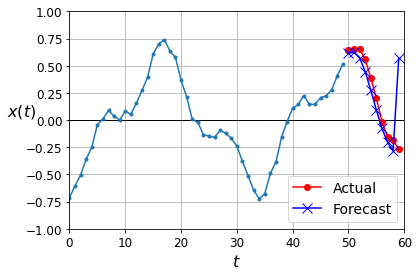

In [26]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

You can combine this approach with the first one: just predict the next 10 values then concatenate to the input series and use the model again and repeat the process. With this approach you can generate arbitrarily long sequences but it may not be accurate for long-term predictions.

### Deep RNN with Layer Normalization

In [27]:
from tensorflow.keras.layers import LayerNormalization

In [28]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 18s 82ms/step - loss: 0.1385 - last_time_step_mse: 0.1315 - val_loss: 0.0593 - val_last_time_step_mse: 0.0517
Epoch 2/20
219/219 [==============================] - 17s 80ms/step - loss: 0.0536 - last_time_step_mse: 0.0456 - val_loss: 0.0495 - val_last_time_step_mse: 0.0418
Epoch 3/20
219/219 [==============================] - 16s 75ms/step - loss: 0.0469 - last_time_step_mse: 0.0390 - val_loss: 0.0446 - val_last_time_step_mse: 0.0372
Epoch 4/20
219/219 [==============================] - 16s 71ms/step - loss: 0.0420 - last_time_step_mse: 0.0339 - val_loss: 0.0398 - val_last_time_step_mse: 0.0320
Epoch 5/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0376 - last_time_step_mse: 0.0289 - val_loss: 0.0352 - val_last_time_step_mse: 0.0268
Epoch 6/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0339 - last_time_step_mse: 0.0246 - val_loss: 0.0328 - val_last_time_step_mse: 0.0237
Epoch 7/20
219/2

## LSTMs

In [30]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0697 - last_time_step_mse: 0.0550 - val_loss: 0.0479 - val_last_time_step_mse: 0.0295
Epoch 2/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0412 - last_time_step_mse: 0.0228 - val_loss: 0.0365 - val_last_time_step_mse: 0.0184
Epoch 3/20
219/219 [==============================] - 11s 48ms/step - loss: 0.0337 - last_time_step_mse: 0.0156 - val_loss: 0.0315 - val_last_time_step_mse: 0.0137
Epoch 4/20
219/219 [==============================] - 10s 48ms/step - loss: 0.0300 - last_time_step_mse: 0.0128 - val_loss: 0.0283 - val_last_time_step_mse: 0.0113
Epoch 5/20
219/219 [==============================] - 11s 48ms/step - loss: 0.0275 - last_time_step_mse: 0.0110 - val_loss: 0.0267 - val_last_time_step_mse: 0.0110
Epoch 6/20
219/219 [==============================] - 11s 48ms/step - loss: 0.0262 - last_time_step_mse: 0.0105 - val_loss: 0.0255 - val_last_time_step_mse: 0.0103
Epoch 7/20
219/2

In [31]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 10ms/step - loss: 0.0197 - last_time_step_mse: 0.0061


[0.01969260722398758, 0.0061402334831655025]

In [32]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

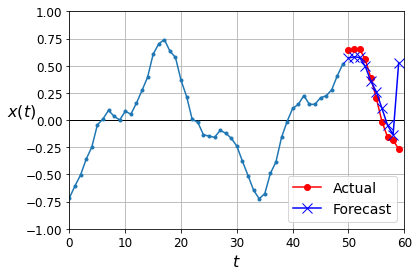

In [33]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## GRUs

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0711 - last_time_step_mse: 0.0628 - val_loss: 0.0459 - val_last_time_step_mse: 0.0351
Epoch 2/20
219/219 [==============================] - 13s 58ms/step - loss: 0.0424 - last_time_step_mse: 0.0328 - val_loss: 0.0401 - val_last_time_step_mse: 0.0301
Epoch 3/20
219/219 [==============================] - 12s 56ms/step - loss: 0.0383 - last_time_step_mse: 0.0282 - val_loss: 0.0362 - val_last_time_step_mse: 0.0258
Epoch 4/20
219/219 [==============================] - 12s 55ms/step - loss: 0.0346 - last_time_step_mse: 0.0245 - val_loss: 0.0326 - val_last_time_step_mse: 0.0227
Epoch 5/20
219/219 [==============================] - 13s 57ms/step - loss: 0.0310 - last_time_step_mse: 0.0209 - val_loss: 0.0291 - val_last_time_step_mse: 0.0190
Epoch 6/20
219/219 [==============================] - 12s 56ms/step - loss: 0.0281 - last_time_step_mse: 0.0174 - val_loss: 0.0265 - val_last_time_step_mse: 0.0152
Epoch 7/20
219/2

In [35]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 10ms/step - loss: 0.0194 - last_time_step_mse: 0.0077


[0.0194486603140831, 0.007651080377399921]

In [36]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

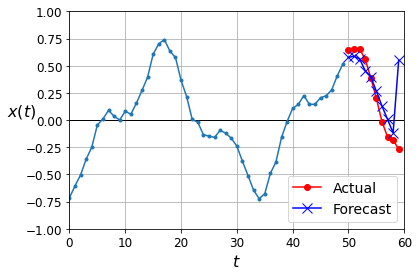

In [37]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Using 1D convolutional layers to process sequences
```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```


In [39]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding='VALID', input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])

history = model.fit(X_train, Y_train[:,3::2], epochs=20, validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0651 - last_time_step_mse: 0.0574 - val_loss: 0.0401 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0344 - last_time_step_mse: 0.0278 - val_loss: 0.0305 - val_last_time_step_mse: 0.0229
Epoch 3/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0285 - last_time_step_mse: 0.0214 - val_loss: 0.0266 - val_last_time_step_mse: 0.0185
Epoch 4/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0252 - last_time_step_mse: 0.0170 - val_loss: 0.0238 - val_last_time_step_mse: 0.0150
Epoch 5/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0228 - last_time_step_mse: 0.0135 - val_loss: 0.0222 - val_last_time_step_mse: 0.0132
Epoch 6/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0210 - last_time_step_mse: 0.0113 - val_loss: 0.0202 - val_last_time_step_mse: 0.0105
Epoch 7/20
219/219 [==

## WaveNet
This architecture has 1D convulational layers stacked, doubling the dilation_rate (how spread apart each neuron's inputs are) at every layer: the first convolutional layer gets a glimpse of just two time steps at a time, while the next one sees four time steps and so on.

This way the lower layers learn short-tem patterns, while the higher layers learn long-term patterns.

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()

model.add(keras.layers.InputLayer(input_shape=[None, 1]))

for rate in (1, 2, 4 ,8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding='causal', activation='relu', dilation_rate=rate))

model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])

history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0616 - last_time_step_mse: 0.0493 - val_loss: 0.0319 - val_last_time_step_mse: 0.0191
Epoch 2/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0285 - last_time_step_mse: 0.0167 - val_loss: 0.0257 - val_last_time_step_mse: 0.0143
Epoch 3/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0246 - last_time_step_mse: 0.0139 - val_loss: 0.0233 - val_last_time_step_mse: 0.0124
Epoch 4/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0226 - last_time_step_mse: 0.0122 - val_loss: 0.0219 - val_last_time_step_mse: 0.0113
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0216 - last_time_step_mse: 0.0115 - val_loss: 0.0212 - val_last_time_step_mse: 0.0110
Epoch 6/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0207 - last_time_step_mse: 0.0106 - val_loss: 0.0202 - val_last_time_step_mse: 0.0098
Epoch 7/20
219/219 [==